### Importing the Libraries

In [11]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [12]:
tf.__version__ 

'2.18.0'

### Part 1 - Data Preprocessing

In [14]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Open the image file
    img = Image.open(image_path)

    # If the image is grayscale (1 channel), convert it to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize the image to the target size
    img = img.resize(target_size)

    # Convert to a numpy array and normalize (optional)
    img_array = np.array(img) / 255.0  # Normalizing the image
    return img_array



In [15]:
def load_and_save_data(directory_path, target_size=(224, 224)):
    # Initialize the ImageDataGenerator for on-the-fly image preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values to [0, 1]
        shear_range=0.2,  # Shear augmentation
        zoom_range=0.2,   # Zoom augmentation
        horizontal_flip=True,  # Flip images horizontally
        validation_split=0.2  # 20% for validation
    )

    # Create an instance of ImageDataGenerator for testing without augmentation
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Define the directories for the training and validation sets
    train_dir = directory_path  # Raw dataset path (directory with class subdirectories)
    test_dir = directory_path   # Assuming the test set is also in the same directory

    # Apply the data generators for training and validation
    train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',  # Change to categorical for one-hot encoding
    subset='training',
)

    validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',  # Change to categorical for one-hot encoding
    subset='validation',
)

    # Apply the test generator for evaluation
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',  # Change to categorical for one-hot encoding
    )

    return train_generator, validation_generator, test_generator

In [16]:
# Example usage
dataset_path = "dataset"  # Replace with your raw dataset path
train_generator, validation_generator, test_generator = load_and_save_data(dataset_path, target_size=(224, 224))

Found 3742 images belonging to 26 classes.
Found 934 images belonging to 26 classes.
Found 4676 images belonging to 26 classes.


### Part 2 - Building the CNN

In [17]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
classifier = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(516, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax') # Assuming 26 classes for letters
])


### Part 3 - Training the CNN

#### Compiling the CNN

In [22]:
classifier.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 516)            │       528,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 516)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │        13,442 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,112,070 (15.69 MB)

 Trainable params: 1,854,086 (7.07 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
print("Output layer shape:", classifier.output_shape)

Output layer shape: (None, 26)


In [24]:
sample_data, sample_labels = next(iter(train_generator))
print("Sample data shape:", sample_data.shape)  # Expected: (batch_size, 224, 224, 3)
print("Sample labels shape:", sample_labels.shape)  # Expected: (batch_size, 26) for categorical

Sample data shape: (32, 224, 224, 3)
Sample labels shape: (32, 26)


#### Training the CNN on the Training set and validating it on the Validation set

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('models/best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history = classifier.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8511 - loss: 0.4179
Epoch 1: val_loss improved from inf to 0.12173, saving model to models/best_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.8513 - loss: 0.4175 - val_accuracy: 0.9582 - val_loss: 0.1217 - learning_rate: 0.0010
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9022 - loss: 0.2878
Epoch 3: val_loss improved from 0.12173 to 0.11077, saving model to models/best_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9022 - loss: 0.2877 - val_accuracy: 0.9668 - val_loss: 0.1108 - learning_rate: 0.0010
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9161 - loss: 0.2501
Epoch 5: val_loss improved from 0.11077 to 

In [29]:
# Evaluate the model on the test data
test_loss, test_accuracy = classifier.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

147/147 ━━━━━━━━━━━━━━━━━━━━ 137s 934ms/step - accuracy: 0.9854 - loss: 0.0495
Test Loss: 0.052728839218616486
Test Accuracy: 0.9846022129058838


In [37]:
best_training_accuracy = max(history.history['accuracy'])
best_validation_accuracy = max(history.history['val_accuracy'])

print(f"Best Training Accuracy: {best_training_accuracy}")
print(f"Best Validation Accuracy: {best_validation_accuracy}")

Best Training Accuracy: 0.9347942471504211
Best Validation Accuracy: 0.9882227182388306


#### Saving the Model

In [38]:
model_json = classifier.to_json()
with open("models/model_new.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')

classifier.save_weights('models/model_new.weights.h5')
print('Weights saved')

Model Saved
Weights saved


### Part 4: Plotting training/validation accuracy and loss

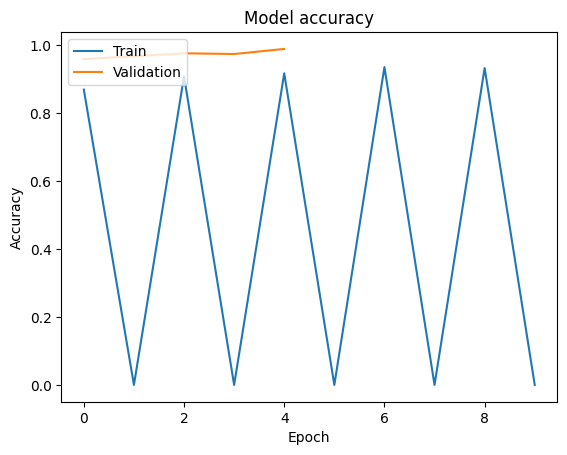

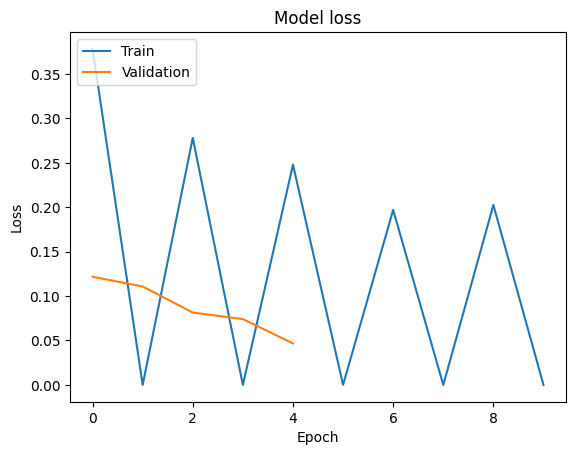

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Part 5: Evaluate model using test generator

In [40]:
y_pred = classifier.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

147/147 ━━━━━━━━━━━━━━━━━━━━ 146s 977ms/step


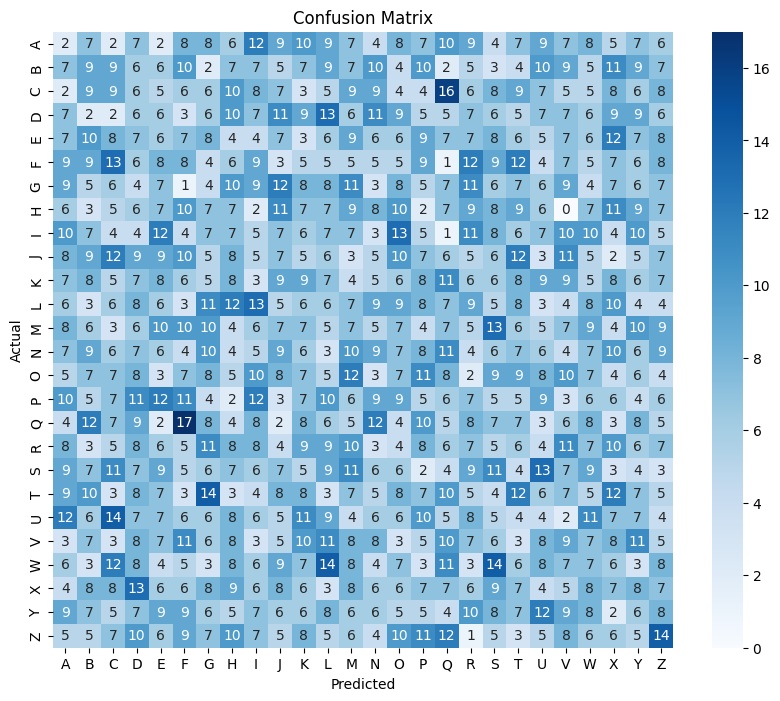

In [41]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       180
           1       0.05      0.05      0.05       180
           2       0.05      0.05      0.05       180
           3       0.03      0.03      0.03       180
           4       0.03      0.03      0.03       180
           5       0.04      0.04      0.04       180
           6       0.02      0.02      0.02       180
           7       0.04      0.04      0.04       180
           8       0.03      0.03      0.03       180
           9       0.04      0.04      0.04       180
          10       0.05      0.05      0.05       180
          11       0.03      0.03      0.03       180
          12       0.04      0.04      0.04       180
          13       0.05      0.05      0.05       180
          14       0.04      0.04      0.04       180
          15       0.03      0.03      0.03       180
          16       0.03      0.03      0.03       178
          17       0.04    

In [43]:
# Evaluate the model on the validation set
loss, accuracy = classifier.evaluate(validation_generator, steps=len(validation_generator))
print(f"Validation accuracy: {accuracy:.4f}")
print(f"Validation loss: {loss:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9897 - loss: 0.0475
Validation accuracy: 0.9872
Validation loss: 0.0510
